Starting with rates, we can build a full working model in equilibrium and non-equilibrium conditions

In [1]:
from multibind.nonequilibrium import rate_matrix
import multibind as mb
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from equil import run # run the equilibrium model
from transport import transport # non-eq model

In [2]:
base = "diffusion"
# base = "md"

rate_files = {'diffusion' : Path('inputs') / 'diffusion_rates.csv',
              'md'        : Path('inputs') / 'md_rates.csv'}
target_dir = {'diffusion' : Path('runs') / 'diffusion',
              'md'        : Path('runs') / 'md'}

outdir = target_dir[base]

transport_magnitudes = { 'diffusion' : [-200, 220],
                         'md'        : [-200, 220],
}[base]

In [3]:
rate_files['md']

PosixPath('inputs/md_rates.csv')

In [4]:
def dG2pKa(dG : float, pH : float = 0.0) -> float:
    '''Calculate the pKa from the free energy difference.
    Defaults to standard state (pH = 0).
    '''
    return pH - dG / np.log(10)

In [5]:
def build_base_multibind_model(pH : float = 8, Na : float = 0.1, verbose = False, leak="small"):
    input_rates = str(rate_files[base])

    if leak != "small":
        if leak == "none":
            input_rates = input_rates.replace("rates.csv", "rates_none.csv")
        elif leak == "large":
            input_rates = input_rates.replace("rates.csv", "rates_large.csv")

    c, k, std = rate_matrix(input_rates)

    states = c.states.values
    free_energies = c.g_mle
    g_std_err = c.std_errors

    new_graph = c.graph.copy()

    for index, data in new_graph.iterrows():
        state1, state2, value, variance, ligand, std = data
        if verbose:
            print(state1, state2, value, variance, ligand, std)

        if (state1[-1] == "H" and state2[-1] == "0") or (state1[-1] == "A" and state2[-1] == "0"):
            # backwards proton reaction
            new_graph.at[index, 'state1'] = state2
            new_graph.at[index, 'state2'] = state1
            new_graph.at[index, 'value'] = -value

            value = new_graph.value[index]
            state1 = new_graph.state1[index]
            state2 = new_graph.state2[index]

        if state1[-1] == "0" and state2[-1] == "H":
            new_graph.at[index, 'ligand'] = "H+"
            new_graph.at[index, 'value'] = dG2pKa(new_graph.value[index], pH)
            new_graph.at[index, 'variance'] = new_graph.variance[index] / np.log(10)**2
        if state1[-1] == "0" and state2[-1] == "A":
            new_graph.at[index, 'ligand'] = "Na+"
            new_graph.at[index, 'value'] = new_graph.value[index] + np.log(Na)

    c_equil = mb.Multibind()
    c_equil.graph = new_graph
    c_equil.states = c.states
    
    return c_equil, k, pH, Na

# Equilibrium

We first read the rates file in and construct a friendlier graph structure. The rate files do not contain any information of ligand species and thus all of the output free energies are reported as raw Helmholtz free energies.

Create blank model, populate it with the new graph and states. Build a scanner from this model.

In [6]:
c_equil, _, _, _ = build_base_multibind_model()

scanner = mb.multibind.MultibindScanner(statefile=None, graphfile=None)
scanner.c = c_equil

Once again, we must provide some metadata since rate files do not have any of this.

In [7]:
sod_bound = {'IF0': 'unbound',
             'IFH': 'unbound',
             'IFNA': 'bound',
             'OF0': 'unbound',
             'OFH': 'unbound',
             'OFNA': 'bound',
            }

prot_bound = {'IF0': 'unbound',
              'IFH': 'bound',
              'IFNA': 'unbound',
              'OF0': 'unbound',
              'OFH': 'bound',
              'OFNA': 'unbound',
             }

conf = {'IF0': 'inward',
        'IFH': 'inward',
        'IFNA': 'inward',
        'OF0': 'outward',
        'OFH': 'outward',
        'OFNA': 'outward',
       }

scanner.c.states['conf'] = list(map(lambda x: conf[x[0]], scanner.c.states.values))
scanner.c.states['prot_bound'] = list(map(lambda x: prot_bound[x[0]], scanner.c.states.values))
scanner.c.states['sod_bound'] = list(map(lambda x: sod_bound[x[0]], scanner.c.states.values))

Run the scanner and output all the images to disk

In [8]:
run(scanner, basepath=outdir);

IFH (0.0) --> IF0 (-3.592878858751014) => -3.592878858751014 ± 0.0930688460419607
IF0 (-3.592878858751014) --> IFNA (-5.014380267629919) => -1.421501408878905 ± 0.09137554990637066
IFNA (-5.014380267629919) --> OFNA (-4.541815452811119) => 0.4725648148188002 ± 0.06600353311491797
OFNA (-4.541815452811119) --> OF0 (-3.8956995146728715) => 0.6461159381382475 ± 0.06283529821426842
OF0 (-3.8956995146728715) --> OFH (-0.47251548686817685) => 3.4231840278046946 ± 0.06538348007307239
OFH (-0.47251548686817685) --> IFH (0.0) => 0.47251548686817685 ± 0.07067892282238342
OF0 (-3.8956995146728715) --> IF0 (-3.592878858751014) => 0.30282065592185736 ± 0.0891139688192351
0.3028206559218573


<Figure size 300x200 with 0 Axes>

<Figure size 300x200 with 0 Axes>

<Figure size 300x200 with 0 Axes>

# Non-equilibrium

Here we collect the cycle flux as a function of sodium concentration and pH

In [22]:
def initialize_structures(voltages=[-0.1, -0.05, 0, 0.05, 0.1], concentrations=[0.001, 0.01, 0.1, 1]):
    display_voltages = np.array(voltages) # membrane voltage range
    voltages = np.concatenate([np.linspace(-0.1, 0.1, 1001)[1:-1], display_voltages]) # make a continuum with desired values
    voltages.sort() # put them in order

    fixed = np.array(concentrations) # fixed sodium concentration range
    na_out = np.concatenate([np.logspace(-3, 0, 20)[1:-1], fixed]) # make continuum
    na_out.sort() # put in order

    data = np.zeros((voltages.shape[0], na_out.shape[0])) # empty memory for results
    
    return voltages, na_out, data


def scan_parameters(voltages, na_out, data, charge_H = 1, charge_N = 1, leak="small"):
    
    c_equil, k, pH, Na = build_base_multibind_model(leak=leak)
    
    for i, v in enumerate(voltages):
        for j, na in enumerate(na_out):
            # rates are taken from the equilibrium case, as they must follow the same closure conditions
            # counter is used if the rates were defined at a particular concentration
            flux, drive, connection_labels, pops, Gp = transport(c_equil, k, 10**-pH, Na, charge_H = charge_H, charge_N = charge_N, **{'c_na_out': na, 'voltage': v})
            data[i, j] = flux
            
def make_plot(voltages, display_voltages, na_out, data, label, vxlim = None, vylim = None, ion_xlabel = r'$[$Na$^+]_{out}$ (M)'):
    
    volt_colors =  ["#0a50a1",
                    "#85a8d0",
                    "#d0cde5",
                    "#f07386",
                    "#e1000c",]
    
    fig, (ax_na, ax_v) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4))

    ax_na.axvline(1-0.075, linestyle='dashed', color='#a1d99b', lw=3)
    ax_na.axvline(0.1, linestyle='dashed', color='#41ab5d', lw=3)
    ax_na.axvline(0.01, linestyle='dashed', color='#00441b', lw=3)

    ax_na.set_xlabel(ion_xlabel)
    ax_na.set_ylabel(r'steady state turnover (s$^{-1}$)')
    
    na_idx001 = np.argwhere(na_out == 0.01)[0][0]
    na_idx01 = np.argwhere(na_out == 0.1)[0][0]
    na_idx1 = np.argwhere(na_out == 1.0)[0][0]
    
    for _i, volt in enumerate(display_voltages):
        i = np.argwhere(voltages == volt)[0][0]
        ax_na.semilogx(na_out, data[i, :], color=volt_colors[_i], label=f'{volt*1000:.0f} mV')
    
    ax_v.plot(voltages*1e3, data[:, na_idx001], color='#00441b', label=f'10 mM')
    ax_v.plot(voltages*1e3, data[:, na_idx01], color='#41ab5d', label=f'100 mM')
    ax_v.plot(voltages*1e3, data[:, na_idx1], color='#a1d99b', label=f'1000 mM')

    ax_v.axvline(0, color='gray', linestyle='dashed')
    ax_v.axhline(0, color='gray', linestyle='dashed')

    ax_v.set_xlabel("memb. voltage (mV)")

    sns.despine(ax=ax_v, offset=5)
    sns.despine(ax=ax_na, offset=5)
    
    ax_na.set_xlim([0.001, 1])
    ax_na.set_ylim(transport_magnitudes)

    if not vylim:
        vylim = transport_magnitudes
    
    ax_v.set_ylim(vylim)
    
    ax_na.legend(loc='best')
    ax_v.legend(loc='best')
    
    outimgdir = outdir / "img" / label
    outimgdir.mkdir(exist_ok=True, parents=True)

    plt.tight_layout()
    plt.savefig(outimgdir / "transport.pdf")
    
    return fig, (ax_na, ax_v)

def make_plot_single(voltages, display_voltages, na_out, data, label, vxlim = None, vylim = None, ion_xlabel = r'$[$Na$^+]_{out}$ (M)'):
    
    volt_colors =  ["#0a50a1",
                    "#85a8d0",
                    "#d0cde5",
                    "#f07386",
                    "#e1000c",]
    
    fig, ax_v = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    
    na_idx001 = np.argwhere(na_out == 0.01)[0][0]
    na_idx01 = np.argwhere(na_out == 0.1)[0][0]
    na_idx1 = np.argwhere(na_out == 1.0)[0][0]
    
    ax_v.set_ylabel(r'steady state turnover (s$^{-1}$)')
    
    ax_v.plot(voltages*1e3, data[:, na_idx001], color='#00441b', label=f'10 mM')
    ax_v.plot(voltages*1e3, data[:, na_idx01], color='#41ab5d', label=f'100 mM')
    ax_v.plot(voltages*1e3, data[:, na_idx1], color='#a1d99b', label=f'1000 mM')

    ax_v.axvline(0, color='gray', linestyle='dashed')
    ax_v.axhline(0, color='gray', linestyle='dashed')

    ax_v.set_xlabel("memb. voltage (mV)")

    sns.despine(ax=ax_v, offset=0)
    
    
    ax_v.set_ylim(transport_magnitudes)
    ax_v.set_xlim(-100, 100)

    if not vylim:
        vylim = transport_magnitudes
    
    ax_v.set_ylim(vylim)
    
    # ax_na.legend(loc='best')
    ax_v.legend(loc='best')
    
    outimgdir = outdir / "img" / label
    outimgdir.mkdir(exist_ok=True, parents=True)

    plt.tight_layout()
    plt.savefig(outimgdir / "transport_single.pdf")
    
    return fig, ax_v

def make_contour(voltages, na_out, data, label, output_file='contour.pdf', ion_label=r'$[$Na$^+]_{out}$ (M)',levels=30, cmap="coolwarm", vmin=-300, vmax=300):
    plt.figure(figsize=(4,4))
    plt.contourf(voltages*1000, na_out, data.T, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.ylabel(ion_label)
    plt.xlabel("memb. voltage (mV)")
    plt.yscale("log")
    plt.tight_layout()

    outimgdir = outdir / "img" / label
    outimgdir.mkdir(exist_ok=True, parents=True)

    plt.tight_layout()

    plt.savefig(outimgdir / output_file)

## Electoneutral

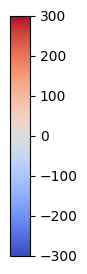

In [23]:
a = np.array([[-300, 300]])
plt.figure(figsize=(0.25, 4))
img = plt.imshow(a, cmap="coolwarm")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)

plt.savefig("img/colorbar.pdf")

Leak: none


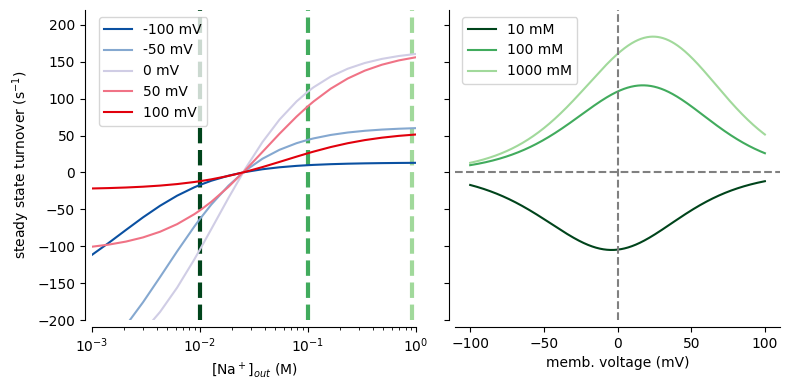

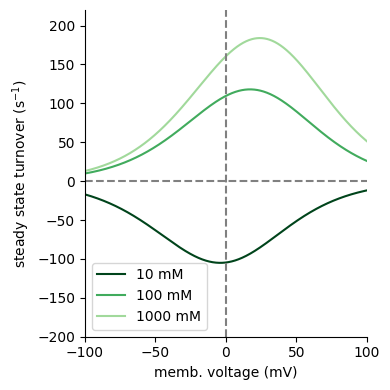

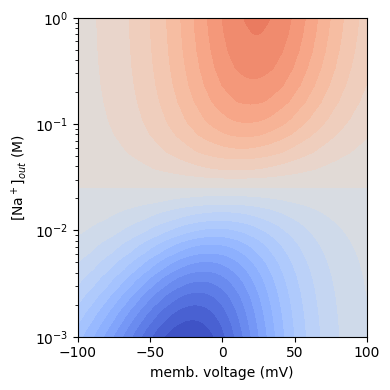

Leak: small


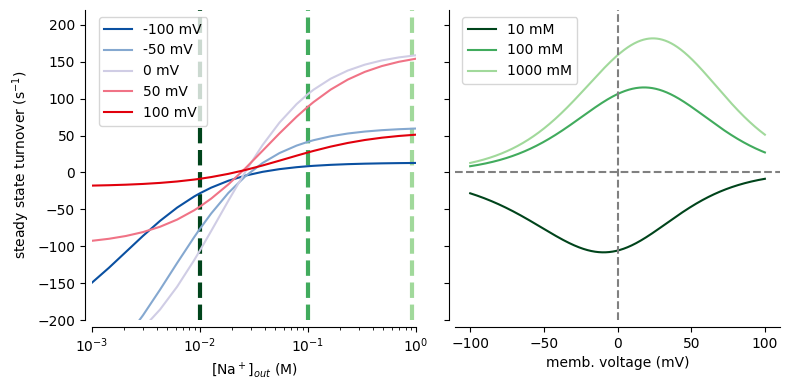

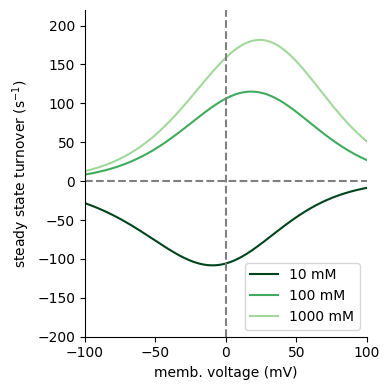

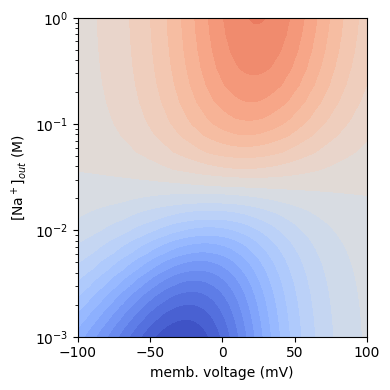

Leak: large


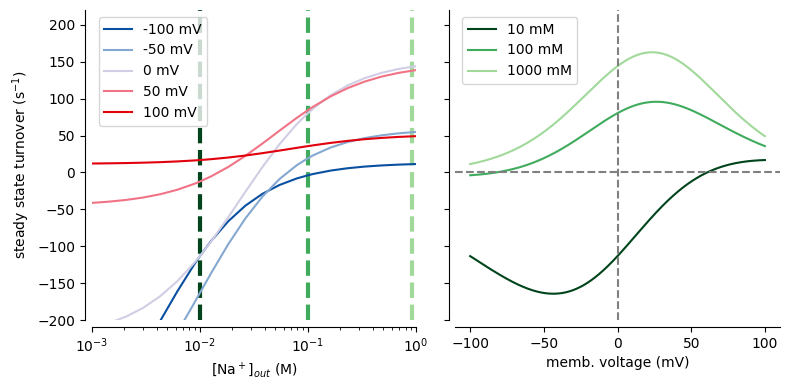

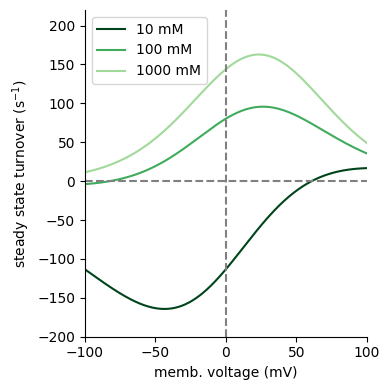

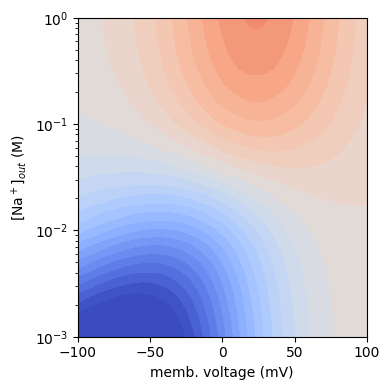

In [24]:
display_voltages = np.array([-0.1, -0.05, 0, 0.05, 0.1]) # membrane voltage range
fixed = np.array([0.001, 0.01, 0.1, 1]) # fixed sodium concentration range

voltages, na_out, data = initialize_structures()

for leak in ['none', 'small', 'large']:
    print(f"Leak: {leak}")
    # mutate data
    scan_parameters(voltages, na_out, data, leak=leak)

    runlabel = f"electroneutral_{leak}"

    make_plot(voltages, display_voltages, na_out, data, runlabel); plt.show()
    make_plot_single(voltages, display_voltages, na_out, data, runlabel); plt.show()
    make_contour(voltages, na_out, data, runlabel); plt.show()
    print("============")


## Electrogenic

We first calculate electrogenic transport treating the sodium as a +2 and the proton as a +1

Leak: none


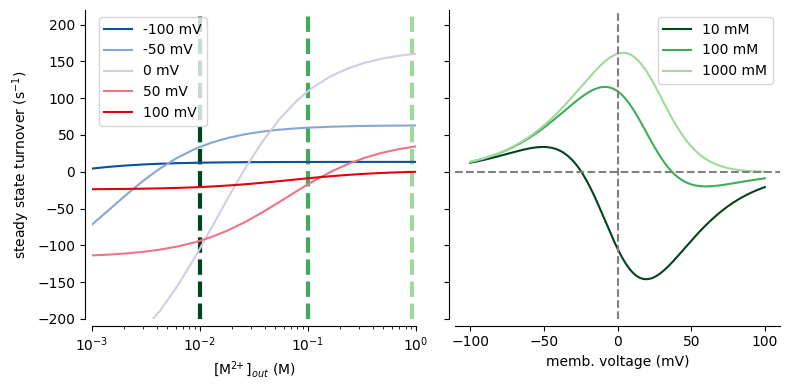

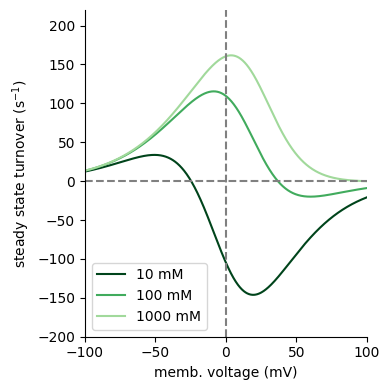

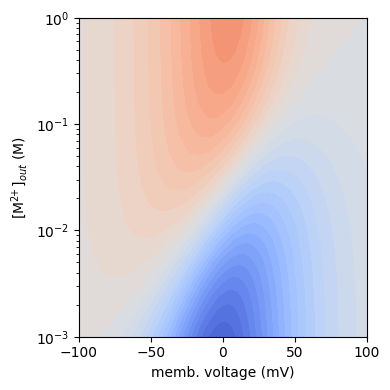

Leak: small


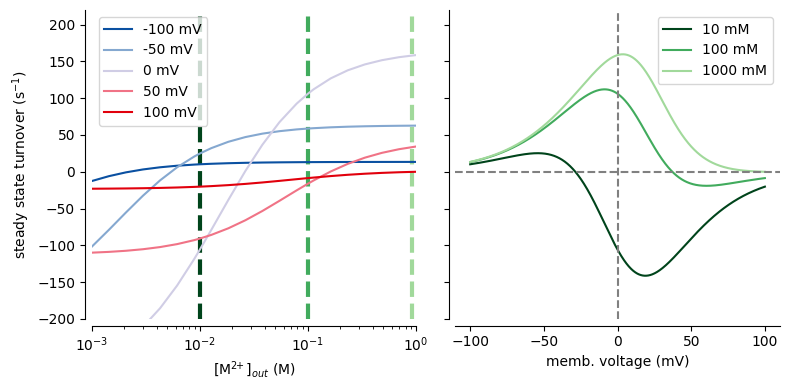

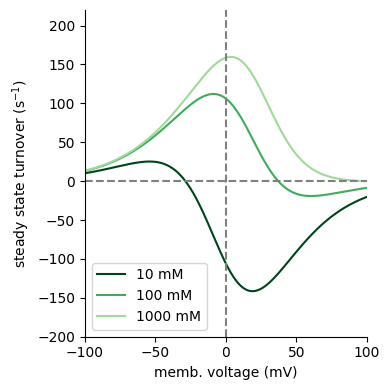

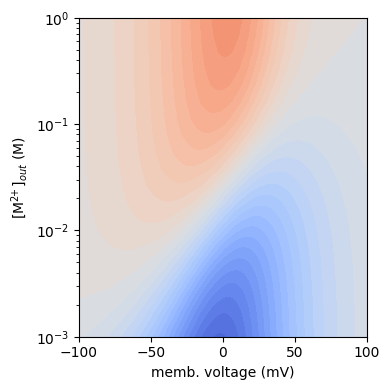

Leak: large


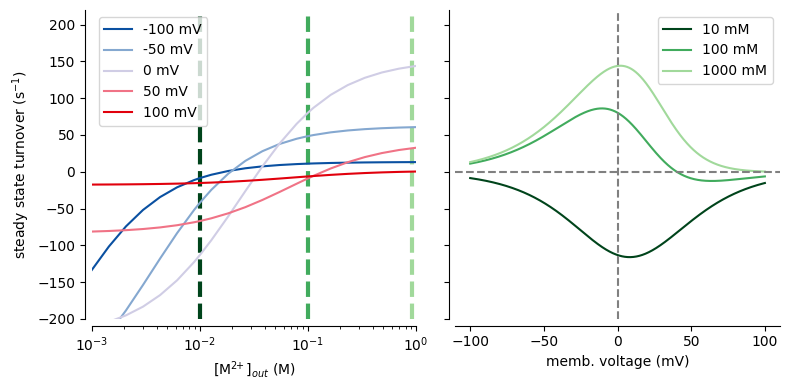

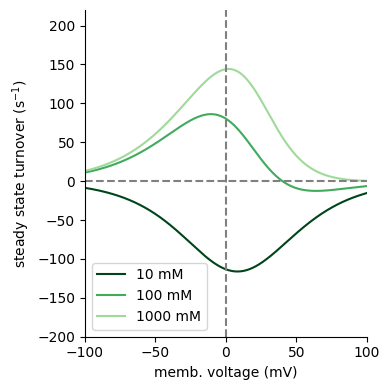

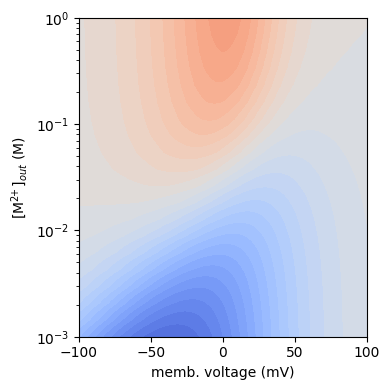

In [12]:
display_voltages = np.array([-0.1, -0.05, 0, 0.05, 0.1]) # membrane voltage range
fixed = np.array([0.001, 0.01, 0.1, 1]) # fixed sodium concentration range
voltages, na_out, data = initialize_structures()

ion_label = r'$[$M$^{2\!\!+}]_{out}$ (M)'

for leak in ['none', 'small', 'large']:
    print(f"Leak: {leak}")
    # mutate data
    scan_parameters(voltages, na_out, data, charge_H = 1, charge_N = 2, leak=leak)

    runlabel = f"electrogenic_{leak}"


    make_plot(voltages, display_voltages, na_out, data, runlabel, ion_xlabel=ion_label); plt.show()
    make_plot_single(voltages, display_voltages, na_out, data, runlabel, ion_xlabel=ion_label); plt.show()
    make_contour(voltages, na_out, data, runlabel, ion_label=ion_label); plt.show()
    print("============")
